In [92]:
#
# 1d shallow water model
#
# solves
# dh/dt + D du/dx = 0
# du/dt + g dh/dx + f*u = 0
#
# staggered discretiztation in space and central in time
#
# o -> o -> o -> o ->   # staggering
# L u  h u  h u  h  R   # element
# 0 1  2 3  4 5  6  7   # index in state vector
#
# m=1/2, 3/2, ...
#  u[n+1,m] + 0.5 g dt/dx ( h[n+1,m+1/2] - h[n+1,m-1/2]) + 0.5 dt f u[n+1,m]
# = u[n  ,m] - 0.5 g dt/dx ( h[n  ,m+1/2] - h[n  ,m-1/2]) - 0.5 dt f u[n  ,m]
# m=1,2,3,...
#  h[n+1,m] + 0.5 D dt/dx ( u[n+1,m+1/2] - u[n+1,m-1/2])
# = h[n  ,m] - 0.5 D dt/dx ( u[n  ,m+1/2] - u[n  ,m-1/2])

import numpy as np
from scipy.sparse import spdiags, csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import timeseries
import dateutil
import datetime

minutes_to_seconds = 60.0
hours_to_seconds = 60.0 * 60.0
days_to_seconds = 24.0 * 60.0 * 60.0


In [93]:
def settings():
    s = dict()  # hashmap to  use s['g'] as s.g in matlab
    # Constants
    s["g"] = 9.81  # acceleration of gravity
    s["D"] = 20.0  # Depth
    s["f"] = 1 / (0.06 * days_to_seconds)  # damping time scale
    L = 100.0e3  # length of the estuary
    s["L"] = L
    n = 100  # number of cells
    s["n"] = n
    # Grid(staggered water levels at 0 (boundary) dx 2dx ... (n-1)dx
    #      velocities at dx/2, 3dx/2, (n-1/2)dx
    dx = L / (n + 0.5)
    s["dx"] = dx
    x_h = np.linspace(0, L - dx, n)
    s["x_h"] = x_h
    s["x_u"] = x_h + 0.5
    # initial condition
    s["h_0"] = np.zeros(n)
    s["u_0"] = np.zeros(n)
    # time
    t_f = 2.0 * days_to_seconds  # end of simulation
    dt = 10.0 * minutes_to_seconds
    s["dt"] = dt
    reftime = dateutil.parser.parse("201312050000")  # times in secs relative
    s["reftime"] = reftime
    t = (
        dt * np.arange(np.round(t_f / dt)) + dt
    )  # MVL moved times to end of each timestep.
    s["t"] = t
    s["t_f"] = t_f

    s["alpha"] = np.exp(-dt / t_f)

    # boundary (western water level)
    # 1) simple function
    # s['h_left'] = 2.5 * np.sin(2.0*np.pi/(12.*hours_to_seconds)*t)
    # 2) read from file
    (bound_times, bound_values) = timeseries.read_series("tide_cadzand.txt")
    bound_t = np.zeros(len(bound_times))
    for i in np.arange(len(bound_times)):
        bound_t[i] = (bound_times[i] - reftime).total_seconds()
    s["h_left"] = np.interp(t, bound_t, bound_values)
    return s


In [94]:
def timestep(x, i, settings):  # return (h,u) one timestep later
    # take one timestep
    temp = x.copy()

    A = settings["A"]
    B = settings["B"]

    w_k = np.random.normal(0, np.sqrt(1 - settings["alpha"]**2) * 0.2)

    A_tilde = csr_matrix((np.shape(A)[0] + 1, np.shape(A)[1] + 1))
    A_tilde[0:-1, 0:-1] = A
    A_tilde[0, -1] = 1
    A_tilde[-1, -1] = settings["alpha"]

    rhs = B.dot(temp[:-1])  # B*x
    rhs[0] = settings["h_left"][i]  # left boundary

    rhs_tilde = np.zeros(len(rhs) + 1)
    rhs_tilde[:-1] = rhs
    rhs_tilde[0] += x[-1]  # N_k
    rhs_tilde[-1] = np.sqrt(1 - settings["alpha"]**2) * w_k

    newx = spsolve(A_tilde, rhs_tilde)

    return newx


In [95]:
def initialize(settings):  # return (h,u,t) at initial time
    # compute initial fields and cache some things for speed
    h_0 = settings["h_0"]
    u_0 = settings["u_0"]
    n = settings["n"]
    # x=np.zeros(2*n) #order h[0],u[0],...h[n],u[n]

    x = np.zeros(2 * n + 1)  # order h[0],u[0],...h[n],u[n]

    # x[0::2]=h_0[:] #MVL 20220329 swapped order
    # x[1::2]=u_0[:]

    x[0:-1:2] = h_0[:]  # MVL 20220329 swapped order
    x[1:-1:2] = u_0[:]

    w_0 = np.random.normal(0, np.sqrt(1 - settings["alpha"]**2) * 0.2)
    x[-1] = w_0

    # time
    t = settings["t"]
    reftime = settings["reftime"]
    dt = settings["dt"]
    times = []
    second = datetime.timedelta(seconds=1)
    for i in np.arange(len(t)):
        times.append(reftime + i * int(dt) * second)
    settings["times"] = times
    # initialize coefficients
    # create matrices in form A*x_new=B*x+alpha
    # A and B are tri-diagonal sparse matrices
    Adata = np.zeros((3, 2 * n))  # order h[0],u[0],...h[n],u[n]
    Bdata = np.zeros((3, 2 * n))
    # left boundary
    Adata[1, 0] = 1.0
    # right boundary
    Adata[1, 2 * n - 1] = 1.0
    # i=1,3,5,... du/dt  + g dh/sx + f u = 0
    #  u[n+1,m] + 0.5 g dt/dx ( h[n+1,m+1/2] - h[n+1,m-1/2]) + 0.5 dt f u[n+1,m]
    # = u[n  ,m] - 0.5 g dt/dx ( h[n  ,m+1/2] - h[n  ,m-1/2]) - 0.5 dt f u[n  ,m]
    g = settings["g"]
    dx = settings["dx"]
    f = settings["f"]
    temp1 = 0.5 * g * dt / dx
    temp2 = 0.5 * f * dt
    for i in np.arange(1, 2 * n - 1, 2):
        Adata[0, i - 1] = -temp1
        Adata[1, i] = 1.0 + temp2
        Adata[2, i + 1] = +temp1
        Bdata[0, i - 1] = +temp1
        Bdata[1, i] = 1.0 - temp2
        Bdata[2, i + 1] = -temp1
    # i=2,4,6,... dh/dt + D du/dx = 0
    #  h[n+1,m] + 0.5 D dt/dx ( u[n+1,m+1/2] - u[n+1,m-1/2])
    # = h[n  ,m] - 0.5 D dt/dx ( u[n  ,m+1/2] - u[n  ,m-1/2])
    D = settings["D"]
    temp1 = 0.5 * D * dt / dx
    for i in np.arange(2, 2 * n, 2):
        Adata[0, i - 1] = -temp1
        Adata[1, i] = 1.0
        Adata[2, i + 1] = +temp1
        Bdata[0, i - 1] = +temp1
        Bdata[1, i] = 1.0
        Bdata[2, i + 1] = -temp1
    # build sparse matrix
    A = spdiags(Adata, np.array([-1, 0, 1]), 2 * n, 2 * n)
    B = spdiags(Bdata, np.array([-1, 0, 1]), 2 * n, 2 * n)
    A = A.tocsr()
    B = B.tocsr()
    settings["A"] = A  # cache for later use
    settings["B"] = B
    return (x, t[0])


In [96]:
def plot_state(fig, x, i, s):
    # plot all waterlevels and velocities at one time
    fig.clear()
    xh = s["x_h"]
    ax1 = fig.add_subplot(211)
    ax1.plot(xh, x[0::2])
    ax1.set_ylabel("h")
    xu = s["x_u"]
    ax2 = fig.add_subplot(212)
    ax2.plot(xu, x[1::2])
    ax2.set_ylabel("u")
    plt.savefig("fig_map_%3.3d.png" % i)
    plt.draw()
    plt.pause(0.1)


def plot_series(t, series_data, s, obs_data):
    # plot timeseries from model and observations
    loc_names = s["loc_names"]
    nseries = len(loc_names)
    for i in range(nseries):
        fig, ax = plt.subplots()
        ax.plot(t, series_data[i, :], "b-")
        ax.set_title(loc_names[i])
        ax.set_xlabel("time")
        ntimes = min(len(t), obs_data.shape[1])
        ax.plot(t[0:ntimes], obs_data[i, 0:ntimes], "k-")

        # Rotate x-tick labels vertically
        plt.xticks(rotation=90)

        # Save figure
        plt.savefig(("%s.png" % loc_names[i]).replace(" ", "_"))
        # plt.close(fig)  # good practice to close the figure after saving


In [97]:
def simulate():
    # for plots
    # plt.close('all')
    # fig1,ax1 = plt.subplots() #maps: all state vars at one time
    # locations of observations
    s = settings()
    L = s["L"]
    dx = s["dx"]
    xlocs_waterlevel = np.array([0.0 * L, 0.25 * L, 0.5 * L, 0.75 * L, 0.99 * L])
    xlocs_velocity = np.array([0.0 * L, 0.25 * L, 0.5 * L, 0.75 * L])
    ilocs = np.hstack(
        (
            np.round((xlocs_waterlevel) / dx) * 2,
            np.round((xlocs_velocity - 0.5 * dx) / dx) * 2 + 1,
        )
    ).astype(int)  # indices of waterlevel locations in x

    loc_names = []
    names = ["Cadzand", "Vlissingen", "Terneuzen", "Hansweert", "Bath"]
    for i in range(len(xlocs_waterlevel)):
        loc_names.append(
            "Waterlevel at x=%.2f km %s" % (0.001 * xlocs_waterlevel[i], names[i])
        )
    for i in range(len(xlocs_velocity)):
        loc_names.append(
            "Velocity at x=%.2f km %s" % (0.001 * xlocs_velocity[i], names[i])
        )
    s["xlocs_waterlevel"] = xlocs_waterlevel
    s["xlocs_velocity"] = xlocs_velocity
    s["ilocs"] = ilocs
    s["loc_names"] = loc_names
    #
    (x, t0) = initialize(s)
    t = s["t"][:]  # [:40]
    times = s["times"][:]  # [:40]
    series_data = np.zeros((len(ilocs), len(t)))
    series_data[:, 0] = x[ilocs]
    noise_data = np.zeros(len(t))
    for i in np.arange(1, len(t)):
        # print('timestep %d'%i)
        x = timestep(x, i, s)
        # plot_state(fig1,x,i,s) #show spatial plot; nice but slow
        series_data[:, i] = x[ilocs]
        noise_data[i] = x[len(x) - 1]

    # load observations
    (obs_times, obs_values) = timeseries.read_series("tide_cadzand.txt")
    observed_data = np.zeros((len(ilocs), len(obs_times)))
    observed_data[0, :] = obs_values[:]
    (obs_times, obs_values) = timeseries.read_series("tide_vlissingen.txt")
    observed_data[1, :] = obs_values[:]
    (obs_times, obs_values) = timeseries.read_series("tide_terneuzen.txt")
    observed_data[2, :] = obs_values[:]
    (obs_times, obs_values) = timeseries.read_series("tide_hansweert.txt")
    observed_data[3, :] = obs_values[:]
    (obs_times, obs_values) = timeseries.read_series("tide_bath.txt")
    observed_data[4, :] = obs_values[:]

    # plot_series(times,series_data,s,observed_data)
    return series_data, observed_data, noise_data


In [98]:
series_data, observed_data, noise_data = simulate()

names = ["Cadzand", "Vlissingen", "Terneuzen", "Hansweert", "Bath"]

for i in range(5):
    error = series_data[i,] - observed_data[i, 1:]
    bias = np.mean(error)  # mean error
    mse = np.sqrt(np.mean(error**2))  # mean squared error

    print(f"{names[i]}: Bias = {bias:.6f}, MSE = {mse:.6f}")


Cadzand: Bias = -0.002611, MSE = 0.041952
Vlissingen: Bias = -0.029102, MSE = 0.387930
Terneuzen: Bias = -0.130393, MSE = 0.603015
Hansweert: Bias = -0.166512, MSE = 0.604891
Bath: Bias = -0.245397, MSE = 0.432703


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


2.039498819761128e-06


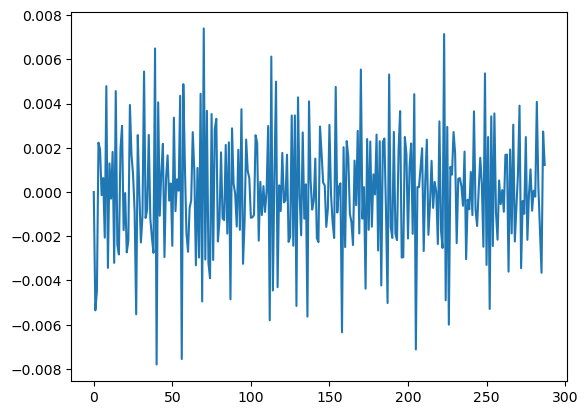

In [103]:
series_data1, observed_data, noise_data = simulate()  # Simulate the data
series_data2, observed_data, noise_data = simulate()  # Simulate the data

print(np.var(noise_data))

plt.figure()  # Create the main figure

plt.plot(
    series_data1[0] - series_data2[0], label=f"Plot {i}"
)  # Plot the data on top of each other
